In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import pi
from scipy.optimize import fmin_l_bfgs_b
from numpy.fft import *
%matplotlib notebook

# Input parametrs

In [382]:
N=10000;Nc=4;Nf=8;Nb=4;L=int(np.sqrt(Nc));
beta=10;
mu=0;
t=1;U=1;V=1
n=1000
matsubara=(2*np.linspace(0,n,n+1)+1)*np.pi/beta

# Fermion k-space

In [383]:
kx=np.linspace(-2*pi,2*pi,2*int(np.sqrt(N))+1);kx=np.delete(kx,0);min_k=np.min(kx);max_k=np.max(kx)
ky=np.linspace(-2*pi,2*pi,2*int(np.sqrt(N))+1);ky=np.delete(ky,0)
kx,ky=np.meshgrid(kx,ky)
E_k=-2*t*(np.cos(kx)+np.cos(ky))

# Boson q-space

In [384]:
qx=np.linspace(-2*pi,2*pi,2*int(np.sqrt(N))+1);qx=np.delete(qx,0);min_q=np.min(qx);max_q=np.max(qx)
qy=np.linspace(-2*pi,2*pi,2*int(np.sqrt(N))+1);qy=np.delete(qy,0)
qx,qy=np.meshgrid(qx,qy)
V_q=2*V*(np.cos(qx)+np.cos(qy))

# Cluster K-space

In [385]:
KX=np.linspace(-pi,pi,L+1);KX=np.delete(KX,0);dK=KX[1]-KX[0];min_K=np.min(KX);max_K=np.max(KX)
KY=np.linspace(-pi,pi,L+1);KY=np.delete(KY,0)
KX,KY=np.meshgrid(KX,KY)

# Patching

In [386]:
G0_K=np.empty((matsubara.size,KX.shape[0],KX.shape[1]),dtype=np.complex128)
E_K=np.empty((KX.shape[0],KX.shape[1]))

P0_K=np.empty((matsubara.size,KX.shape[0],KX.shape[1]),dtype=np.complex128)
V_K=np.empty((KX.shape[0],KX.shape[1]))

for i in xrange(L):
    for j in xrange(L):  
            indexes_k=((kx>(KX[i,j]-dK/2.))&(kx<(KX[i,j]+dK/2.)))&((ky>(KY[i,j]-dK/2.))&(ky<(KY[i,j]+dK/2.)))
            indexes_q=((qx>(KX[i,j]-dK/2.))&(qx<(KX[i,j]+dK/2.)))&((qy>(KY[i,j]-dK/2.))&(qy<(KY[i,j]+dK/2.)))
            for k in xrange(matsubara.size):
                G0_K[k,i,j]=Nc*np.sum((1j*matsubara[k]+mu-E_k[indexes_k])**(-1))/N
                P0_K[k,i,j]=Nc*np.sum((V_q[indexes_q])**(-1))/N
            E_K[i,j]=Nc*np.sum(E_k[indexes_k])/N
            V_K[i,j]=Nc*np.sum(V_q[indexes_q])/N
        

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in reciprocal


<IPython.core.display.Javascript object>


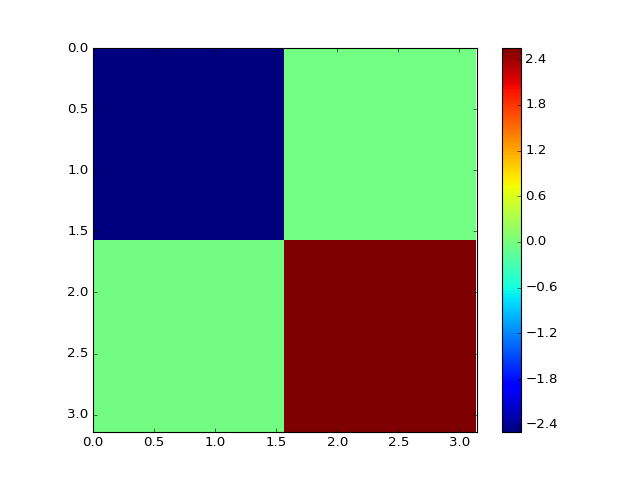

In [387]:
plt.figure()
plt.imshow(E_K,interpolation='None', extent=(min_K,max_K, max_K, min_K))
plt.colorbar()

<IPython.core.display.Javascript object>


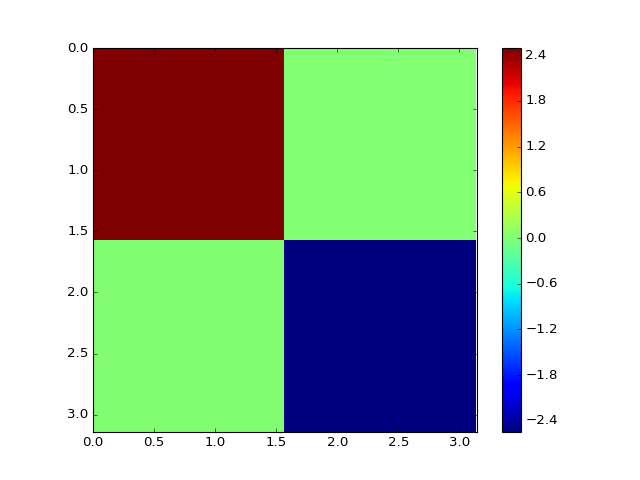

In [388]:
plt.figure()
plt.imshow(V_K,interpolation='None', extent=(min_K,max_K, max_K, min_K))
plt.colorbar()

# Transform matrix

In [369]:
T=np.array([[1,1,1,1],[1,-1,-1,1],[1,-1,1,-1],[1,1,-1,-1]])/2.

In [370]:
T

array([[ 0.5,  0.5,  0.5,  0.5],
       [ 0.5, -0.5, -0.5,  0.5],
       [ 0.5, -0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5, -0.5]])

# Find Hamiltonian parametrs

In [410]:
from numpy.linalg import inv

In [411]:
from scipy.optimize import fmin_l_bfgs_b

In [423]:
G0_R=np.zeros_like(G0_K);P0_R=np.zeros_like(P0_K);
for i in xrange(matsubara.size):
    G0_R[i,:,:]=ifft2(ifftshift(G0_K[i,:,:]))
    P0_R[i,:,:]=ifft2(ifftshift(P0_K[i,:,:]))
G0_IJ=np.zeros((matsubara.size,Nc,Nc),dtype=np.complex128)
P0_IJ=np.zeros((matsubara.size,Nc,Nc),dtype=np.complex128)

for i in xrange(Nc):
    for j in xrange(Nc):
        x=i%L-j%L;y=i//L-j//L
        if x<0: x=x+L
        if y<0: y=y+L
        G0_IJ[:,i,j]=G0_R[:,x,y]
        P0_IJ[:,i,j]=P0_R[:,x,y]

In [413]:
G0_M=np.zeros_like(G0_IJ)
P0_M=np.zeros_like(P0_IJ)
for i in xrange(matsubara.size):
    G0_M[i,:,:]=(inv(T).dot(G0_IJ[i,:,:])).dot(T)
    P0_M[i,:,:]=(inv(T).dot(P0_IJ[i,:,:])).dot(T)
h=np.random.random(Nf);
ek=np.random.random(Nf);
em=np.random.random(Nc);


In [414]:
def molecular_GF(parameters):
    em=parameters[0];h=parameters[1:Nf/Nc+1];ek=parameters[Nf/Nc+1:]
    G0=np.zeros(matsubara.size,dtype=np.complex128)
    for i in xrange(matsubara.size):
        G0[i]=(1j*matsubara[i]+mu-em-np.sum(h**2/(1j*matsubara[i]-ek)))**(-1)
    return G0

In [415]:
bounds=[]
bounds.append((-4*t,4*t))
for i in xrange(Nf/Nc):
    bounds.append((0.01*t,4*t))
    
for i in xrange(Nf/Nc):
    bounds.append((-4*t,4*t))
    
parameters=[]
for i in xrange(Nc):
    p_inp=2*np.random.random(1+2*Nf/Nc)-1;G0_real=G0_M[:,i,i]
    def error_hyb_function(parameters):
        G0=molecular_GF(parameters)
        return np.sum(np.abs(np.conj(G0-G0_real)*(G0-G0_real))/matsubara)
    p_res=fmin_l_bfgs_b(error_hyb_function, x0=p_inp,approx_grad=True,disp=True,bounds=bounds)
    parameters.append(p_res[0])

In [416]:
em=np.zeros((Nc,Nc));h=np.zeros((Nc,Nf));ek=np.zeros(Nf)
for i in xrange(Nc):
    em[i,i]=parameters[i][0]
    h [i,i*Nf/Nc:(i*Nf/Nc+Nf/Nc)]=parameters[i][1:Nf/Nc+1]
    ek[i*Nf/Nc:(i*Nf/Nc+Nf/Nc)]=parameters[i][Nf/Nc+1:]

In [417]:
np.round(em,2)

array([[ 1.67,  0.  ,  0.  ,  0.  ],
       [ 0.  , -2.52,  0.  ,  0.  ],
       [ 0.  ,  0.  , -0.03,  0.  ],
       [ 0.  ,  0.  ,  0.  , -0.03]])

In [418]:
np.round((inv(T).dot(em)).dot(T),2)

array([[-0.23,  1.05,  1.05, -0.2 ],
       [ 1.05, -0.23, -0.2 ,  1.05],
       [ 1.05, -0.2 , -0.23,  1.05],
       [-0.2 ,  1.05,  1.05, -0.23]])

In [419]:
np.round(h,2)

array([[ 1.44,  0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.71,  0.84,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.53,  0.54,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.53,  0.54]])

In [420]:
np.round(T.dot(np.abs(h)),2)

array([[ 0.72,  0.  ,  0.36,  0.42,  0.26,  0.27,  0.26,  0.27],
       [ 0.72,  0.  , -0.36, -0.42, -0.26, -0.27,  0.26,  0.27],
       [ 0.72,  0.  , -0.36, -0.42,  0.26,  0.27, -0.26, -0.27],
       [ 0.72,  0.  ,  0.36,  0.42, -0.26, -0.27, -0.26, -0.27]])

In [421]:
np.round(ek,2)

array([-4.  , -3.81, -1.22,  4.  ,  0.46, -0.48,  0.46, -0.48])

<IPython.core.display.Javascript object>


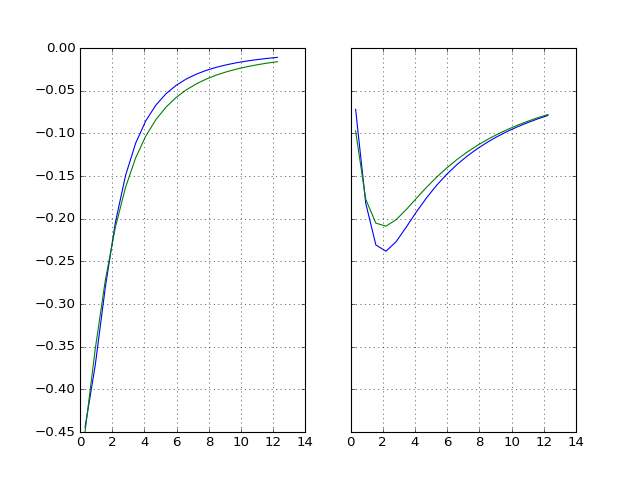

<IPython.core.display.Javascript object>


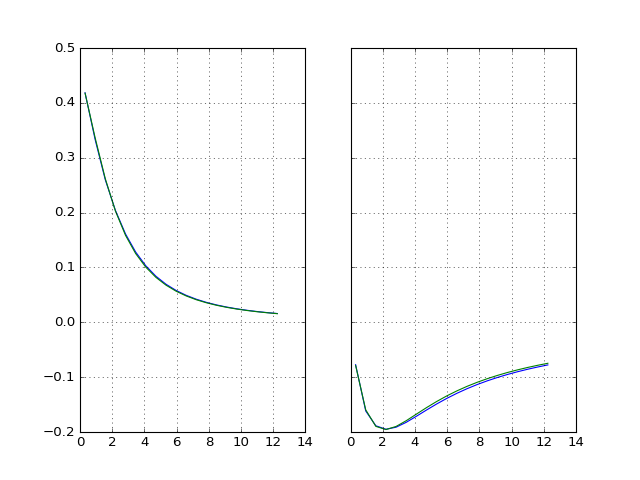

<IPython.core.display.Javascript object>


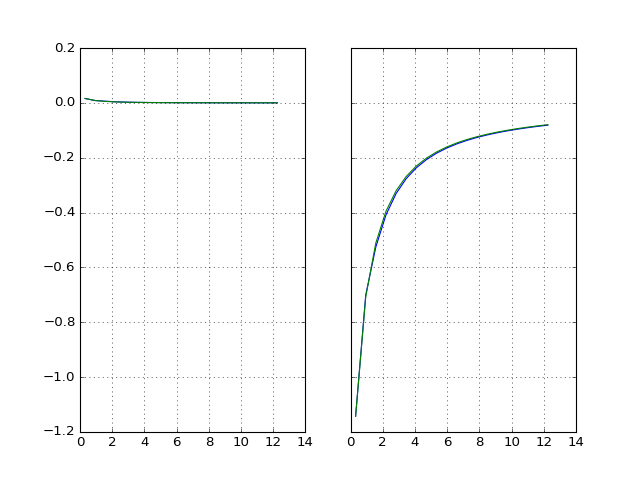

<IPython.core.display.Javascript object>


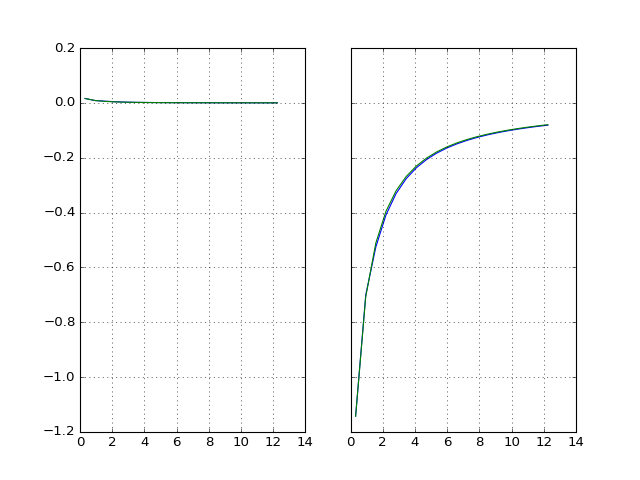

In [422]:
for i in xrange(Nc):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    ax1.plot(matsubara[:20],molecular_GF(parameters[i])[:20].real)
    ax1.plot(matsubara[:20],G0_M[:,i,i][:20].real)
    ax1.grid()
    
    ax2.plot(matsubara[:20],molecular_GF(parameters[i])[:20].imag)
    ax2.plot(matsubara[:20],G0_M[:,i,i][:20].imag)
    ax2.grid()